In [1]:
import numpy as np
import sys
import os
import numpy as np
from pandas import read_csv
from skimage import io, transform
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
import tensorboardX as tbx
import argparse
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import logging
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not os.path.exists('./log'):
    os.mkdir('./log') 
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M',
                    filename='./log/log.txt',
                    filemode='w')
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

In [3]:
rootdir = '../data'
csvfile = rootdir + '/all.csv'
labels = np.genfromtxt(csvfile,delimiter=',',usecols=0,dtype=str)
data = np.genfromtxt(csvfile,delimiter=',')[:,1:]
head = ["angle","toMarking_L","toMarking_M","toMarking_R","dist_L","dist_R","toMarking_LL",
        "toMarking_ML","toMarking_MR","toMarking_RR","dist_LL","dist_MM","dist_RR","velocity",
        "inter","lane"]

Total sample:  41587


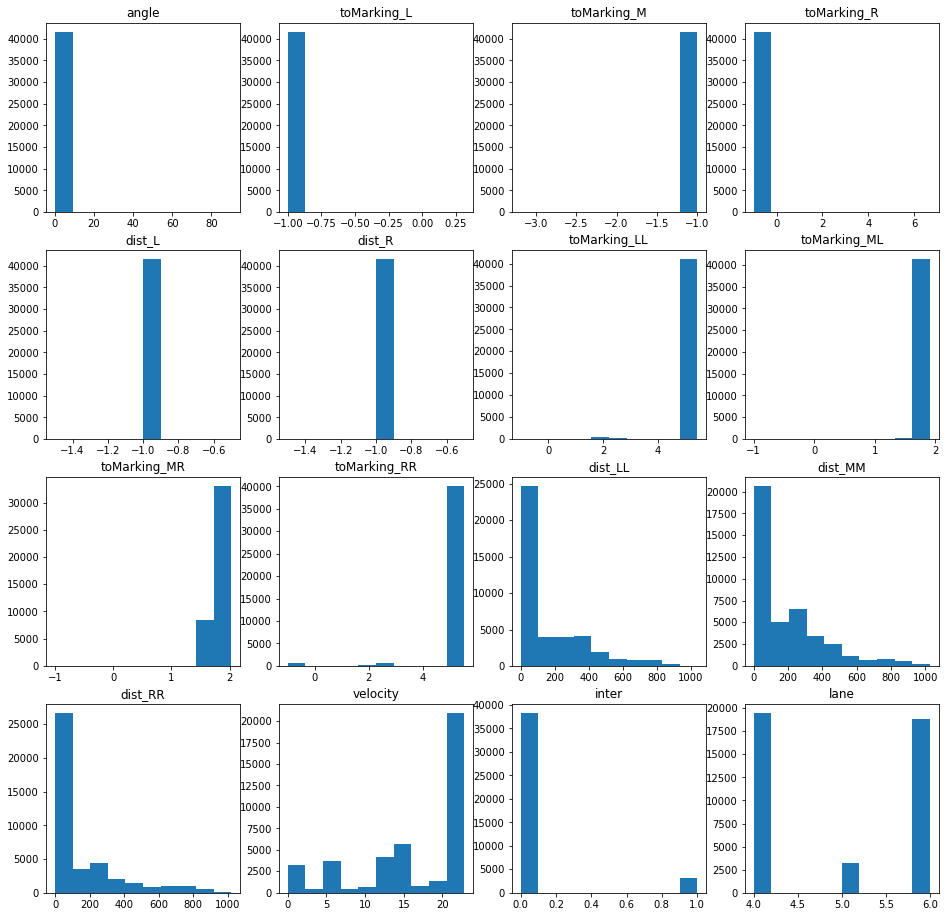

In [4]:
print("Total sample: ",len(data))
fig, axs = plt.subplots(4, 4, figsize=(16,16))
for i in range(4):
    for j in range(4):
        axs[i, j].hist(data[:,4*i+j])
        axs[i, j].set_title(head[4*i+j])


In [5]:
valid = [0] + [i for i in range(6,14)]
print(valid)
print(len(valid))

value_range = [
    (-0.5,  0.5), # angle        
    (-7,   -2.5), # toMarking_L  
    (-2,    3.5), # toMarking_M  
    ( 2.5,  7),   # toMarking_R  
    ( 0,    75),  # dist_L       
    ( 0,    75),  # dist_R       
    (-9.5, -4),   # toMarking_LL 
    (-5.5, -0.5), # toMarking_ML 
    ( 0.5,  5.5), # toMarking_MR 
    ( 4,    9.5), # toMarking_RR 
    ( 0,    75),  # dist_LL      
    ( 0,    75),  # dist_MM      
    ( 0,    75),  # dist_RR      
    ( 0,    1)    # fast         
]

min_nv = 0.1
max_nv = 0.9

[0, 6, 7, 8, 9, 10, 11, 12, 13]
9


In [6]:
def normalize(av):
    def f(v, r):
        v = float(v)
        min_v = float(r[0])
        max_v = float(r[1])
        v = (v - min_v) / (max_v - min_v)
        v = v * (max_nv - min_nv) + min_nv
        v = min(max(v, 0.0), 1.0)
        return v

    for (i, v) in enumerate(av):
        av[i] = f(v, value_range[i])
    
    return av

def denormalize(av):
    def f(v, r):
        v = float(v)
        min_v = float(r[0])
        max_v = float(r[1])
        v = (v - min_nv) / (max_nv - min_nv)
        v = v * (max_v - min_v) + min_v
        return v

    for (i, v) in enumerate(av):
        av[i] = f(v, value_range[i])
    
    return av

In [7]:
class CarlaDataset(Dataset):
    """CARLA dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        self.metadata = read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx,0].split('-')
        img_name = os.path.join(self.root_dir,img_id[0],img_id[1],"{}.png".format(img_id[2]))
        image = io.imread(img_name)
               
        # Delete alpha channel
        if image.shape[-1] == 4:
            image = np.delete(image, 3, 2)
        
        # Scale to 280x210
        image = transform.resize(image, (210, 280, 3), mode='constant', anti_aliasing=True)

        # Make it CHW
        image = image.transpose(2, 0, 1).astype('float32')
               
        av = self.metadata.iloc[idx,1:].values
        av = av.astype('float32')
        av = av[valid]
        #av = normalize(av)
        sample = {'image': image, 'affordance_vector': av}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [8]:
random_seed= 25
carla_dataset = CarlaDataset(csv_file=csvfile, root_dir=rootdir)
dataset_size = len(carla_dataset)
print(dataset_size)

41587


In [9]:
def random_checkN(carla_dataset,N=5):
    for i in range(N):
        idx = np.random.randint(0,len(carla_dataset))
        sample = carla_dataset[idx]
        print("Sample #{}".format(idx))
        for i,v in enumerate(valid):
            print("  {}:{}".format(head[v],sample["affordance_vector"][i]), end=" ")
        io.imshow(sample["image"][1,:,:])
        io.show()

Sample #34055
  angle:0.010589599609375   toMarking_LL:5.250163555145264   toMarking_ML:1.7501635551452637   toMarking_MR:1.7498364448547363   toMarking_RR:5.249836444854736   dist_LL:170.79144287109375   dist_MM:307.31781005859375   dist_RR:281.8605651855469   velocity:22.569944381713867 

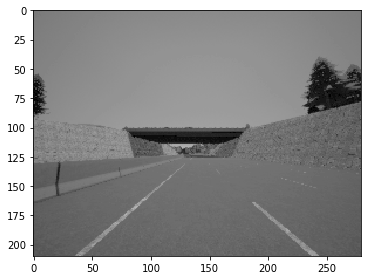

Sample #21691
  angle:0.01531982421875   toMarking_LL:5.250068187713623   toMarking_ML:1.750068187713623   toMarking_MR:1.749931812286377   toMarking_RR:5.249931812286377   dist_LL:-1.0   dist_MM:-1.0   dist_RR:184.93511962890625   velocity:22.507226943969727 

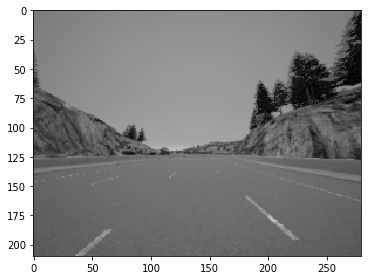

Sample #41369
  angle:0.6001129150390625   toMarking_LL:5.261810302734375   toMarking_ML:1.761810302734375   toMarking_MR:1.738189697265625   toMarking_RR:5.238189697265625   dist_LL:567.7996826171875   dist_MM:-1.0   dist_RR:-1.0   velocity:22.161720275878906 

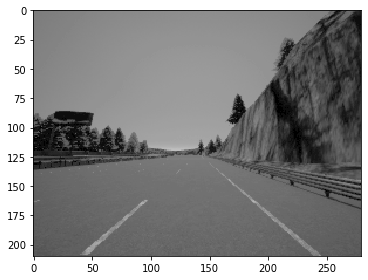

Sample #32513
  angle:0.0014280675677582622   toMarking_LL:5.2499542236328125   toMarking_ML:1.7499542236328125   toMarking_MR:1.7500457763671875   toMarking_RR:5.2500457763671875   dist_LL:329.34332275390625   dist_MM:318.64349365234375   dist_RR:-1.0   velocity:14.68921947479248 

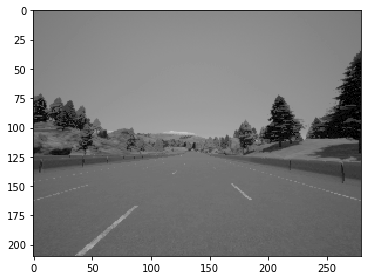

Sample #22571
  angle:0.2841339111328125   toMarking_LL:5.224814414978027   toMarking_ML:1.7248144149780273   toMarking_MR:1.7751855850219727   toMarking_RR:5.275185585021973   dist_LL:-1.0   dist_MM:38.51853561401367   dist_RR:-1.0   velocity:18.94219970703125 

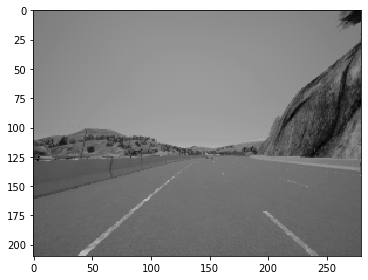

In [10]:
random_checkN(carla_dataset,5)

In [11]:
validation_split = .2
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = DataLoader(carla_dataset, batch_size=64, num_workers=16, pin_memory=True, sampler=train_sampler)
validation_dataloader = DataLoader(carla_dataset, batch_size=64, num_workers=16, pin_memory=True, sampler=valid_sampler)

In [12]:
class DDAlexNet(nn.Module):
    def __init__(self,output):
        super(DDAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.regression = nn.Sequential(
            nn.Linear(256*5*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, output)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 35)
        x = self.regression(x)
        return x

In [13]:
net = DDAlexNet(len(valid)).cuda()
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(net.parameters(),lr=0.01)

train_writer = tbx.SummaryWriter('./log/train')
valid_writer = tbx.SummaryWriter('./log/valid')

# Enable to see model
summary(net, (3, 210, 280))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 51, 69]          34,944
              ReLU-2           [-1, 96, 51, 69]               0
         MaxPool2d-3           [-1, 96, 25, 34]               0
 LocalResponseNorm-4           [-1, 96, 25, 34]               0
            Conv2d-5          [-1, 256, 25, 34]         614,656
              ReLU-6          [-1, 256, 25, 34]               0
         MaxPool2d-7          [-1, 256, 12, 16]               0
 LocalResponseNorm-8          [-1, 256, 12, 16]               0
            Conv2d-9          [-1, 256, 12, 16]         590,080
             ReLU-10          [-1, 256, 12, 16]               0
        MaxPool2d-11            [-1, 256, 5, 7]               0
           Linear-12                 [-1, 4096]      36,704,256
             ReLU-13                 [-1, 4096]               0
          Dropout-14                 [-

In [14]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight)
net.apply(init_normal)

DDAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regression): Sequential(
    (0): Linear(in_features=8960, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=

In [15]:
for epoch in range(20):
    train_loss_tot = 0
    train_num = 0 
    valid_loss_tot = 0
    valid_num = 0

    for i, train_sample in enumerate(train_dataloader):
        train_inputs = train_sample['image'].cuda()
        train_target = train_sample['affordance_vector'].cuda()

        train_outputs = net(train_inputs)
        #print(train_inputs.cpu())
        #print('target:{}'.format(train_sample['affordance_vector'][0]))
        #print('outputs:{}'.format(train_outputs.cpu()[0]))
        train_loss = criterion(train_outputs, train_target)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        #logging.info("Epoch:{}, Sample:{}, Training Loss:{}".format(epoch,i,train_loss))
        train_loss_tot += train_loss
        train_num += train_inputs.size(0)
        #train_writer.add_scalar('Loss', train_loss.item(), epoch)

    with torch.no_grad():
        for i, valid_sample in enumerate(validation_dataloader):
            valid_inputs = valid_sample['image'].cuda()
            valid_target = valid_sample['affordance_vector'].cuda()
            valid_outputs = net(valid_inputs)
            valid_loss = criterion(valid_outputs,valid_target)
            #logging.info("Epoch:{}, Sample:{}, Validating Loss:{}".format(epoch,i,valid_loss))
            valid_loss_tot += valid_loss
            valid_num += valid_inputs.size(0)
            #valid_writer.add_scalar('Loss', valid_loss.item(), epoch)

    logging.info("Epoch:{}, Training Samples:{}, Training Loss:{}".format(epoch,train_num,train_loss_tot/train_num))
    logging.info("Epoch:{}, Validating Samples:{}, Validating Loss:{}".format(epoch,valid_num,valid_loss_tot/valid_num))
    train_writer.add_scalar('Loss', train_loss_tot/train_num, epoch)
    valid_writer.add_scalar('Loss', valid_loss_tot/valid_num, epoch)

KeyboardInterrupt: 